## makemore: becoming a backprop ninja

swole doge style

In [1]:
# there no change change in the first several cells from last lecture

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# ok biolerplate done, now we get to the action:

In [7]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(variable_name: str, derivative_tensor: torch.Tensor, tensor: torch.Tensor):
  ex = torch.all(derivative_tensor == tensor.grad).item()
  app = torch.allclose(derivative_tensor, tensor.grad)
  maxdiff = (derivative_tensor - tensor.grad).abs().max().item()
  print(f'{variable_name:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for tensor in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  tensor.retain_grad()
loss.backward()
loss

tensor(3.3440, grad_fn=<NegBackward0>)

In [137]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
d_log_probs = torch.zeros_like(logprobs)
d_log_probs[range(n), Yb] = -1/n
d_probs = (1/ probs) * d_log_probs 
d_counts_sum_inverse =  (d_probs * counts).sum(1, keepdim=True)
d_counts = counts_sum_inv * d_probs
d_counts_sum = (-counts_sum **-2) * d_counts_sum_inverse
d_counts+= torch.ones_like(counts) * d_counts_sum
d_norm_logits = norm_logits.exp() * d_counts
d_logits = d_norm_logits.clone()
d_logit_maxes = (-d_logits).sum(1, keepdim=True)
d_logits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * d_logit_maxes
d_h = d_logits @ W2.T
d_W2 = h.T @ d_logits
d_b2 = d_logits.sum(0, keepdim=True)
d_h_preactivation = (1 - h **2)  * d_h
d_bn_gain = (bnraw * d_h_preactivation).sum(0, keepdim=True) 
d_bn_raw = bngain * d_h_preactivation
d_bn_bias = d_h_preactivation.sum(0, keepdim=True)
d_bn_var_inv = (d_bn_raw * bndiff).sum(0, keepdim=True)
d_bn_diff = d_bn_raw * bnvar_inv 
d_bn_var = (-0.5*(bnvar + 1e-5) **-1.5) * d_bn_var_inv
d_bn_diff2 = 1/(n-1) * torch.ones_like(bndiff2) * d_bn_var
d_bn_diff += (bndiff*2) * d_bn_diff2
d_hprebn = d_bn_diff.clone()
d_bnmeani = (-d_bn_diff).sum(0)
d_hprebn += 1/n * torch.ones_like(hprebn) * d_bnmeani
d_embcat = d_hprebn @ W1.T
d_W1 = embcat.T @ d_hprebn
d_b1 = d_hprebn.sum(0, keepdim=True)
d_emb = d_embcat.view(-1, 3,10)
d_C = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    d_C[ix] += d_emb[k,j]
print(f'{d_bn_raw.shape=}')
print(f'{bndiff.shape=}')
print(f'{bnvar_inv.shape=}')

cmp('logprobs', d_log_probs, logprobs)
cmp('probs', d_probs, probs)
cmp('counts_sum_inv', d_counts_sum_inverse, counts_sum_inv)
cmp('counts', d_counts, counts)
cmp('countssum', d_counts_sum, counts_sum)
cmp('norm_logits', d_norm_logits, norm_logits)
cmp('logit_maxes', d_logit_maxes, logit_maxes)
cmp('logits', d_logits, logits)
cmp('h', d_h, h)
cmp('w2', d_W2, W2)
cmp('b2', d_b2, b2)
cmp('hpreact', d_h_preactivation, hpreact)
cmp('bngain', d_bn_gain, bngain)
cmp('bnraw', d_bn_raw, bnraw)
cmp('bnbias', d_bn_bias, bnbias)
cmp('bnvar_inv', d_bn_var_inv, bnvar_inv)
cmp('bndiff', d_bn_diff, bndiff)
cmp('bnvar', d_bn_var, bnvar)
cmp('bnvar', d_bn_var, bnvar)
cmp('bndiff2', d_bn_diff2, bndiff2)
cmp('bnhprebn', d_hprebn, hprebn)
cmp('bnmeani', d_bnmeani, bnmeani)
cmp('embcat', d_embcat, embcat)
cmp('W1', d_W1, W1)
cmp('b1', d_b1, b1)
cmp('emb', d_emb, emb)
cmp('C', d_C, C)



d_bn_raw.shape=torch.Size([32, 64])
bndiff.shape=torch.Size([32, 64])
bnvar_inv.shape=torch.Size([1, 64])
logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
countssum       | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact

In [77]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape


(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [121]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

a = torch.randn(100, generator=g)
a.var(unbiased=False)

tensor(1.1503)

In [14]:
# dlogprobs = torch.zeros_like(logprobs)
# dlogprobs[range(n), Yb] = -1.0/n
# dprobs = (1.0 / probs) * dlogprobs
# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# dcounts = counts_sum_inv * dprobs
# dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
# dcounts += torch.ones_like(counts) * dcounts_sum
# dnorm_logits = counts * dcounts
# dlogits = dnorm_logits.clone()
# dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
# dh = dlogits @ W2.T
# dW2 = h.T @ dlogits
# db2 = dlogits.sum(0)
# dhpreact = (1.0 - h**2) * dh
# dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
# dbnraw = bngain * dhpreact
# dbnbias = dhpreact.sum(0, keepdim=True)
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
# dembcat = dhprebn @ W1.T
# dW1 = embcat.T @ dhprebn
# db1 = dhprebn.sum(0)
# demb = dembcat.view(emb.shape)
# dC = torch.zeros_like(C)
# for k in range(Xb.shape[0]):
#   for j in range(Xb.shape[1]):
#     ix = Xb[k,j]
#     dC[ix] += demb[k,j]

# cmp('logprobs', dlogprobs, logprobs)
# cmp('probs', dprobs, probs)
# cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# cmp('counts_sum', dcounts_sum, counts_sum)
# cmp('counts', dcounts, counts)
# cmp('norm_logits', dnorm_logits, norm_logits)
# cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

In [15]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3439695835113525 diff: -2.384185791015625e-07


In [16]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


In [17]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [18]:
F.softmax(logits, 1)[0]

tensor([0.0704, 0.0857, 0.0192, 0.0487, 0.0197, 0.0911, 0.0241, 0.0362, 0.0171,
        0.0314, 0.0355, 0.0363, 0.0397, 0.0282, 0.0345, 0.0133, 0.0093, 0.0175,
        0.0163, 0.0538, 0.0472, 0.0210, 0.0275, 0.0686, 0.0610, 0.0259, 0.0207],
       grad_fn=<SelectBackward0>)

In [19]:
dlogits[0] * n

tensor([ 0.0704,  0.0857,  0.0192,  0.0487,  0.0197,  0.0911,  0.0241,  0.0362,
        -0.9829,  0.0314,  0.0355,  0.0363,  0.0397,  0.0282,  0.0345,  0.0133,
         0.0093,  0.0175,  0.0163,  0.0538,  0.0472,  0.0210,  0.0275,  0.0686,
         0.0610,  0.0259,  0.0207], grad_fn=<MulBackward0>)

In [20]:
dlogits[0].sum()

tensor(1.8626e-09, grad_fn=<SumBackward0>)

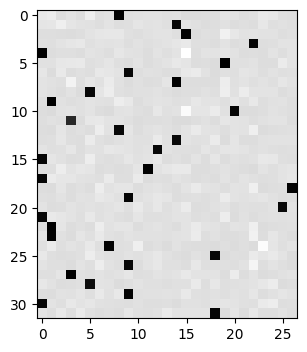

In [21]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [22]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(9.5367e-07, grad_fn=<MaxBackward1>)


In [23]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

NameError: name 'dhpreact' is not defined

In [188]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [189]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    d_C = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        d_C[ix] += demb[k,j]
    grads = [d_C, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7924
  10000/ 200000: 2.1668


KeyboardInterrupt: 

In [23]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [24]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [25]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0709383487701416
val 2.1114068031311035


In [26]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
amille.
khi.
mili.
taty.
skanden.
jazonel.
den.
arciereni.
nellara.
chaiivon.
leigh.
ham.
joce.
quint.
salin.
alianni.
waterra.
jarisi.
jace.


In [17]:
import torch

# set parameters
sample_size = 10
input_features = 1
iterations = 1
learning_rate = 1

# initialise variables
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
x = torch.arange(0,4, dtype=torch.float32).view(-1,1)
print(f'{x=}')
# x = torch.randn((sample_size, input_features), generator=g)
w = torch.ones((input_features, 1)) #+ -1
# b = torch.zeros((1, input_features))  # Fix: Reshaped b to be (1, fan_out)
trainable = [
        w, 
        # b
    ]
for tensor in trainable:
    tensor.requires_grad = True


for i in range(iterations):
    # forward pass
    preactivation = x @ w  # + b
    activation = preactivation#.relu()
    losses = (0 - activation).abs()
    total_loss = losses.mean()
    print(f"{i=} {total_loss.item()}")

    # backward pass
    for tensor in trainable:
        tensor.grad = None
    total_loss.backward()

    # run updates
    for tensor in trainable:
        grads = tensor.grad
        updates = -learning_rate * tensor.grad
        tensor.data += updates 
    print(f'{x=}')
    print(f'{w=}')
    print(f'{w.grad=}')
    print(f'{activation=}')
    print(f'{losses=}')
    print(f'{total_loss=}')

   
# print(f'{w=}')     
# (torch.arange(-2,3, dtype=torch.float32).view(-1,1) @ w).relu()


x=tensor([[0.],
        [1.],
        [2.],
        [3.]])
i=0 1.399999976158142
x=tensor([[0.],
        [1.],
        [2.],
        [3.]])
w=tensor([[-0.5000]], requires_grad=True)
w.grad=tensor([[1.5000]])
activation=tensor([[0.],
        [1.],
        [2.],
        [3.]], grad_fn=<MmBackward0>)
losses=tensor([[0.2000],
        [0.8000],
        [1.8000],
        [2.8000]], grad_fn=<AbsBackward0>)
total_loss=tensor(1.4000, grad_fn=<MeanBackward0>)


In [33]:
loss_grads = torch.sign(0 - activation) * (1/sample_size)
(loss_grads * x).mean()


tensor(-0.1500, grad_fn=<MeanBackward0>)

In [46]:
# ... existing code ...

# The correct derivative calculation
# For loss = |0 - activation|.mean() = |−activation|.mean()

# The derivative of |x| is sign(x)
# For our case, x = -activation
# So d|−activation|/dactivation = sign(-activation) * (-1) = -sign(-activation)

# Since activation is positive (x=[0,1,2,3] and w starts at 1),
# sign(-activation) = -1, so the derivative is -(-1) = 1

dloss_dactivation = 1.0 * (1/len(x))  # Correct derivative
dactivation_dpreactivation = 1.0  # Identity function derivative
dpreactivation_dw = x

# Combine them all (chain rule)
manual_w_grad = torch.zeros_like(w)
for i in range(len(x)):
    manual_w_grad += dloss_dactivation[i] * dactivation_dpreactivation * dpreactivation_dw[i]

print(f'Manually calculated w.grad: {manual_w_grad}')
print(f'PyTorch calculated w.grad: {w.grad}')
# ... existing code ...

TypeError: 'float' object is not subscriptable

In [122]:
import torch

n = 5
a = torch.arange(1, n+1, dtype=torch.float32, requires_grad=True)
b = torch.arange(-1, n-1, dtype=torch.float32, requires_grad=True)

# Compute operations
ab = a @ b  # Dot product
ab.retain_grad()  # Retain grad for non-leaf tensor
lab = a.log()  # Log operation
loss = lab.mean()  # Mean loss

# Backward pass
loss.backward()

# Print gradients
print(f'{a.grad=}')  
print(f'{b.grad=}')  
print(f'{ab.grad=}')  
print(f'{ab}')  

a.grad=tensor([0.2000, 0.1000, 0.0667, 0.0500, 0.0400])
b.grad=None
ab.grad=None
25.0
